# 深度Q网络

只能用于离散动作，异策略训练

# 导入包

In [1]:
import rl_utils
import numpy as np
import random
import gymnasium as gym
import collections
import tqdm
import torch
import torch.nn.functional as F
import os

# 经验缓存

In [2]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity)
        
    def add(self, state, action, reward, next_state, done, truncated):
        self.buffer.append((state, action, reward, next_state, done, truncated))
    
    def sample(self, batch_size):
        transitions = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done, truncated = zip(*transitions)
        return np.array(state), action, reward, np.array(next_state), done, truncated  # 多返回了一个state(?)

# Q网络

In [3]:
class Qnet(torch.nn.Module):
    def __init__(self, state_dim=4, hidden_dim=128, action_dim=2):
        super().__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)
    
    def forward(self, x):
        x = F.elu(self.fc1(x))
        x = F.elu(self.fc2(x))
        return self.fc3(x)

# 补充/Dueling Q网络

In [4]:
class VAnet(torch.nn.Module):
    ''' 只有一层隐藏层的A网络和V网络 '''
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(VAnet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)  # 共享网络部分
        self.fc_A = torch.nn.Linear(hidden_dim, action_dim)
        self.fc_V = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x):
        A = self.fc_A(F.relu(self.fc1(x)))
        V = self.fc_V(F.relu(self.fc1(x)))
        Q = V + A - A.mean(-1).view(-1, 1)  # Q值由V值和A值计算得到
        return Q

# DQN算法

In [5]:
class DQN:
    ''' DQN算法 '''
    def __init__(self, state_dim, hidden_dim, action_dim, learning_rate, gamma,
                 epsilon, target_update, dqn_type, device):
        self.action_dim = action_dim
        if dqn_type == 'DuelingDQN':  #======># Dueling DQN采取不一样的网络框架
            self.q_net = VAnet(state_dim, hidden_dim,
                               self.action_dim).to(device)
            self.target_q_net = VAnet(state_dim, hidden_dim,
                                      self.action_dim).to(device)
        else:
            self.q_net = Qnet(state_dim, hidden_dim,
                              self.action_dim).to(device)
            self.target_q_net = Qnet(state_dim, hidden_dim,
                                     self.action_dim).to(device)
        # 使用Adam优化器
        self.optimizer = torch.optim.Adam(self.q_net.parameters(), lr=learning_rate)
        self.gamma = gamma  # 折扣因子
        self.epsilon = epsilon  # epsilon-贪婪策略
        self.target_update = target_update  # 目标网络更新频率
        self.count = 0  # 计数器,记录更新次数
        self.dqn_type = dqn_type
        self.device = device

    def take_action(self, state):  # epsilon-贪婪策略采取动作
        if np.random.random() < self.epsilon:
            action = np.random.randint(self.action_dim)
        else:
            state = torch.tensor(state, dtype=torch.float).to(self.device)
            action = self.q_net(state).argmax().item() # 转成动作序号
        return action

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'], dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions'], dtype=torch.int64).view(-1, 1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'], dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'], dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'], dtype=torch.int).view(-1, 1).to(self.device)
        truncated = torch.tensor(transition_dict['truncated'], dtype=torch.int).view(-1, 1).to(self.device)

        q_values = self.q_net(states).gather(1, actions)  # 模型预测本状态Q值
        # 👆 tensor.gather(1, actions) 按行取, 索引为动作序号
        if self.dqn_type == 'DoubleDQN' or 'DuelingDQN':  # 先在q网络确定动作, 再对应到目标网络的价值上
            max_action = self.q_net(next_states).max(1)[1].view(-1, 1)
            max_next_q_values = self.target_q_net(next_states).gather(1, max_action)
        else:
            max_next_q_values = self.target_q_net(next_states).max(1)[0].view(-1, 1) # 下个状态的最大Q值
            # 👆 tensor.max(1)[0], (1)是指按行取最大,(0)按列; [0]是取值,[1]取序号,等于argmax
        q_targets = rewards + self.gamma * max_next_q_values * (1 - (dones | truncated))  # TD误差目标
        dqn_loss = torch.mean(F.mse_loss(q_values, q_targets))  # 均方误差损失函数
        self.optimizer.zero_grad()  # * 🟠 PyTorch中默认梯度会积累,比如多次求梯度会加总,这里需要显式将梯度置为0
        dqn_loss.backward()  # 反向传播更新参数
        self.optimizer.step()  # 执行优化

        if self.count % self.target_update == 0:
            self.target_q_net.load_state_dict(self.q_net.state_dict())  # 更新目标网络
        self.count += 1

# 初始化参数

In [6]:
# 环境相关
env_name = 'CartPole-v1'
env = gym.make(env_name, render_mode='rgb_array')

# DQN相关
total_epoch = 20  # 迭代数
s_epoch = 0 # 默认开始位置
total_episode = 100  # 每次迭代最大游戏轮数
max_step = 500
gamma = 0.98
epsilon = 1  # 刚开始随机动作,更新中线性降低
target_update = 20  # 若干回合更新一次目标网络
buffer_size = 10000  # 经验大小
minimal_size = 1000  # 最小经验数
batch_size = 128
best_score = 0  # 每回合中的最佳分数
replay_buffer = ReplayBuffer(buffer_size)
return_list = []
best_weight = 0

# 神经网络相关
lr = 2e-3
hidden_dim = 128
state_dim = env.observation_space.shape[0]  # 状态空间大小
action_dim = env.action_space.n  # 动作空间大小
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
agent = DQN(state_dim, hidden_dim, action_dim, lr, gamma, epsilon,
            target_update, 'DuelingDQN',device)

# 随机数种子
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

# 检查点函数

In [7]:
def read_ckp(CKP_PATH):
    if os.path.exists(CKP_PATH):
        checkpoint = torch.load(CKP_PATH)
        s_epoch = checkpoint['epoch']
        s_episode = checkpoint['episode']
        epsilon = checkpoint['epsilon']
        agent.q_net.load_state_dict(checkpoint['best_weight'])
        return_list = checkpoint['return_list']
        return s_epoch, s_episode, epsilon, return_list
    else:
        s_epoch = 0
        s_episode = 0
        epsilon = 1  # 训练时要改的，随意初始化
        return_list = []
        return s_epoch, s_episode, epsilon, return_list

## 读取检查点

In [8]:
PATH = 'checkpoints/DQN_CPv1.pt'
s_epoch, s_episode, epsilon, return_list = read_ckp(PATH)
replay_buffer = rl_utils.ReplayBuffer(buffer_size)

# 训练

In [9]:
for epoch in range(s_epoch, total_epoch):
    with tqdm.tqdm(total=total_episode, desc='<%d/%d>'%(epoch+1, total_epoch), leave=False) as pbar:
        for episode in range(total_episode):
            episode_return = 0
            state = env.reset()[0]
            done = truncated = False
            step = 0
            while (not (done | truncated)) and step < max_step:  # 执行单次游戏, 最多max_step步
                action = agent.take_action(state)
                next_state, reward, done, truncated, info = env.step(action)
                replay_buffer.add(state, action, reward, next_state, done, truncated)
                state = next_state
                episode_return += reward
                # 当buffer数据的数量超过一定值后,才进行Q网络训练
                if len(replay_buffer.buffer) > minimal_size:
                    b_s, b_a, b_r, b_ns, b_d, b_t = replay_buffer.sample(batch_size)
                    transition_dict = {
                        'states': b_s,
                        'actions': b_a,
                        'next_states': b_ns,
                        'rewards': b_r,
                        'dones': b_d,
                        'truncated': b_t
                    }
                    agent.update(transition_dict)  # 获得经验中抽取的样本, 拟合网络并且梯度上升
                    step += 1 # 步数加一
                    
                    # 获得最佳权重
                    if step > best_score:
                        best_weight = agent.q_net.state_dict()
                        best_score = step
                    
            return_list.append(episode_return)
            
            if (episode + 1) % 10 == 0:  # 显示过去10次游戏情况
                pbar.set_postfix({
                    'train_times':
                    '%d' % (total_episode * epoch + episode + 1),  # 至今一共训练了多少次游戏
                    'recent_reward':
                    '%.1f' % np.mean(return_list[-10:]),
                    'episilon':
                    '%.2f' % agent.epsilon
                })
                
            # 调整epsilon
            agent.epsilon = max(1 - epoch / (total_epoch / 2), 0.01)
            
            # 保存检查点
            torch.save({
                'epoch': epoch,
                'episode': episode,
                'best_weight': best_weight,
                'epsilon': epsilon,
                'return_list': return_list,
                }, PATH)
            pbar.update(1)  # 更新进度条
print()
agent.q_net.load_state_dict(best_weight)  # 应用最佳权重

<All keys matched successfully>

## 作图

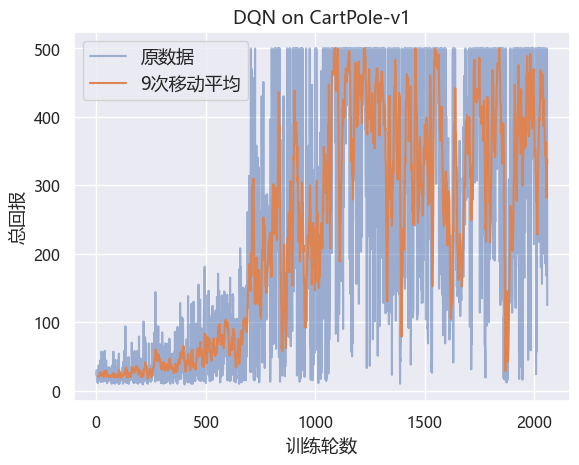

In [10]:
rl_utils.picture_return(return_list, 'DQN', env_name, 9)

In [9]:
rl_utils.show_gym_policy(env_name, agent.q_net, 'V', 'human', 10, 500)

[500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0]

# Dueling DQN对比

## 初始化参数

In [21]:
# 环境相关
PATH = 'checkpoints/ckpt_dueling_dqn_CPv1.pt'
env_name = 'CartPole-v1'
env = gym.make(env_name, render_mode='rgb_array')

# DQN相关
total_epoch = 20  # 迭代数
s_epoch = 0 # 默认开始位置
total_episode = 100  # 每次迭代最大游戏轮数
max_step = 500
gamma = 0.98
epsilon = 1  # 刚开始随机动作,更新中线性降低
target_update = 20  # 若干回合更新一次目标网络
buffer_size = 10000  # 经验大小
minimal_size = 1000  # 最小经验数
batch_size = 128
best_score = 0  # 每回合中的最佳分数
replay_buffer = ReplayBuffer(buffer_size)
return_list = []
best_weight = 0

# 神经网络相关
lr = 2e-3
hidden_dim = 128
state_dim = env.observation_space.shape[0]  # 状态空间大小
action_dim = env.action_space.n  # 动作空间大小
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print('device: ', device)
agent = DQN(state_dim, hidden_dim, action_dim, lr, gamma, epsilon,
            target_update, 'DuelingDQN',device)

# 随机数种子
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

## 读取检查点

In [ ]:
PATH = 'checkpoints/ckpt_dqn_PDv1.pt'  # ! 迁移部署后按情况修改, 若已修改, 去掉叹号
s_epoch, s_episode, epsilon, return_list = read_ckp(PATH)
replay_buffer = rl_utils.ReplayBuffer(buffer_size)

## 训练

In [22]:
for epoch in range(s_epoch, total_epoch):
    with tqdm.tqdm(total=total_episode, desc='<%d/%d>'%(epoch+1, total_epoch), leave=False) as pbar:
        for episode in range(total_episode):
            episode_return = 0
            state = env.reset()[0]
            done = truncated = False
            step = 0
            while (not (done | truncated)) and step < max_step:  # 执行单次游戏, 最多max_step步
                action = agent.take_action(state)
                next_state, reward, done, truncated, info = env.step(action)
                replay_buffer.add(state, action, reward, next_state, done, truncated)
                state = next_state
                episode_return += reward
                # 当buffer数据的数量超过一定值后,才进行Q网络训练
                if len(replay_buffer.buffer) > minimal_size:
                    b_s, b_a, b_r, b_ns, b_d, b_t = replay_buffer.sample(batch_size)
                    transition_dict = {
                        'states': b_s,
                        'actions': b_a,
                        'next_states': b_ns,
                        'rewards': b_r,
                        'dones': b_d,
                        'truncated': b_t
                    }
                    agent.update(transition_dict)  # 获得经验中抽取的样本, 拟合网络并且梯度上升
                    step += 1 # 步数加一
                    
                    # 获得最佳权重
                    if step > best_score:
                        best_weight = agent.q_net.state_dict()
                        best_score = step
                    
            return_list.append(episode_return)
            
            if (episode + 1) % 10 == 0:  # 显示过去10次游戏情况
                pbar.set_postfix({
                    'train_times':
                    '%d' % (total_episode * epoch + episode + 1),  # 至今一共训练了多少次游戏
                    'recent_reward':
                    '%.1f' % np.mean(return_list[-10:]),
                    'episilon':
                    '%.2f' % agent.epsilon
                })
                
            # 调整epsilon
            agent.epsilon = max(1 - epoch / (total_epoch / 2), 0.01)
            
            # 保存检查点
            torch.save({
                'epoch': epoch,
                'episode': episode,
                'best_weight': best_weight,
                'epsilon': epsilon,
                'return_list': return_list,
                }, PATH)
            
            pbar.update(1)  # 更新进度条
agent.q_net.load_state_dict(best_weight)  # 应用最佳权重

<All keys matched successfully>

## 作图

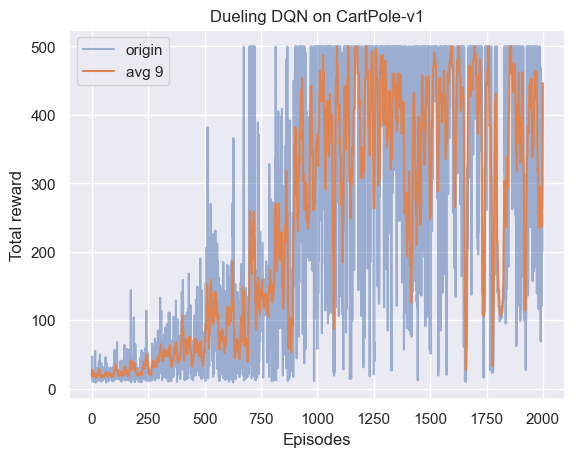

In [23]:
rl_utils.picture_reward(return_list, 'Dueling DQN', env_name, 9)